<a href="https://colab.research.google.com/github/srinithish/Deep-Learning/blob/master/HW3_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import sklearn
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import matplotlib.cm as cm
import math
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

In [0]:
### load all files 


from google.colab import drive
drive.mount('/content/Drive',force_remount =  True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/Drive


In [0]:
###load files
# !pip install librosa # in colab, you'll need to install this
import librosa
import io


"""
Change directory path here and leave it blank if its in the same directory as the 
Notebook
"""
dirpath  = "Drive/My Drive/Deeplearning Assignment/timit-homework"
# dirpath  = ""


### Loading the files

def gen_STFTnMagnitude(filepath):
  """
  returns 
  time domain 
  complex spectrogram 
  magnitude spectrgoram
  """
  RawAmpVsTime, sr=librosa.load(filepath, sr=None)
  spectrogram = librosa.stft(RawAmpVsTime, n_fft=1024, hop_length=512)
  spectrogram = np.transpose(spectrogram)
  spectrogram_Mag = np.abs(spectrogram)
  
  return RawAmpVsTime,spectrogram,spectrogram_Mag




# print(X1_test.shape)

In [0]:
#### load all train files
def loadFiles(filepattern):
  
  spectrogramList = []
  RawAmpVsTimeList = []
  spectrogram_Mag_List = []
#   print(dirpath+filepattern)
  print(glob.glob(dirpath+filepattern))

  for file in sorted(glob.glob(dirpath+filepattern)):
    
    RawAmpVsTime,spectrogram,spectrogram_Mag = gen_STFTnMagnitude(file)

    RawAmpVsTimeList.append(RawAmpVsTime)
    spectrogramList.append(spectrogram)
    spectrogram_Mag_List.append(spectrogram_Mag)

  dictOfLists = {'RawAmpVsTimeList':RawAmpVsTimeList, 
                      'spectrogramList': spectrogramList, 
                      'spectrogram_MagList': spectrogram_Mag_List}
  return dictOfLists



# dictOfTrainXFiles = loadFiles('/tr/trx*')
# dictOfTrainYFiles = loadFiles('/tr/trs*')
# dictOfTrainNoiseFiles = loadFiles('/tr/trn*')

# dictOfValidationXFiles = loadFiles('/v/vx*')
# dictOfValidationYFiles = loadFiles('/v/vs*')
# dictOfValidationNoiseFiles = loadFiles('/v/vn*')

# dictOfTestXFiles = loadFiles('/te/tex*')





In [0]:

###dumping pickle objects
# import pickle
# with open(dirpath+'/dictOfTrainXFiles.pkl', 'wb') as f:
#   pickle.dump(dictOfTrainXFiles, f)
  
# with open(dirpath+'/dictOfTrainYFiles.pkl', 'wb') as f:
#   pickle.dump(dictOfTrainYFiles, f)

# with open(dirpath+'/dictOfTrainNoiseFiles.pkl', 'wb') as f:
#   pickle.dump(dictOfTrainNoiseFiles, f)
  
# with open(dirpath+'/dictOfValidationXFiles.pkl', 'wb') as f:
#   pickle.dump(dictOfValidationXFiles, f)
  
# with open(dirpath+'/dictOfValidationYFiles.pkl', 'wb') as f:
#   pickle.dump(dictOfValidationYFiles, f)

# with open(dirpath+'/dictOfValidationNoiseFiles.pkl', 'wb') as f:
#   pickle.dump(dictOfValidationNoiseFiles, f)

# with open(dirpath+'/dictOfTestXFiles.pkl', 'wb') as f:
#   pickle.dump(dictOfTestXFiles, f)


In [0]:

##getting pickled files
import pickle
with open(dirpath+'/dictOfTrainXFiles.pkl', 'rb') as f:
  dictOfTrainXFiles = pickle.load(f)
  
with open(dirpath+'/dictOfTrainYFiles.pkl', 'rb') as f:
  dictOfTrainYFiles = pickle.load(f)

with open(dirpath+'/dictOfTrainNoiseFiles.pkl', 'rb') as f:
  dictOfTrainNoiseFiles = pickle.load(f)
  
with open(dirpath+'/dictOfValidationXFiles.pkl', 'rb') as f:
  dictOfValidationXFiles = pickle.load(f)
  
with open(dirpath+'/dictOfValidationYFiles.pkl', 'rb') as f:
  dictOfValidationYFiles = pickle.load(f)

with open(dirpath+'/dictOfValidationNoiseFiles.pkl', 'rb') as f:
  dictOfValidationNoiseFiles = pickle.load(f)

with open(dirpath+'/dictOfTestXFiles.pkl', 'rb') as f:
  dictOfTestXFiles = pickle.load(f)

In [0]:
##masked output
def maskOutput(SignalList,NoiseList):
  Mask = []
  for i in range(len(SignalList)):
    
    Mask.append(np.greater(SignalList[i],NoiseList[i])*1)
  
  return Mask
    


#### Fully connected and RNN Layer structure

In [0]:
# Parameters
learning_rate = 0.001


# Network Parameters
RNNStructure = [513,513] ### 513  neuron layer stacked with another 513 neuron layer
FullyConnectedStructure = [256] ### One with 513 output with sigmoid activation.


In [0]:
# (numExamples,xDim) = XSpectrogramMag.shape
# (numExamples,yDim) = YSpectrogramMag.shape
xDim = 513
yDim = 513
X = tf.placeholder("float", [None,None, xDim])
Y = tf.placeholder("float", [None,None, yDim])
# SeqLen = tf.placeholder(tf.int32, [None])

timeSteps = tf.placeholder(tf.int32)
RNNDropout_keepProb = tf.placeholder(tf.float32)

In [0]:
def defineWeightsAndBias(FullyConnectedStructure,xDim, yDim):
  
  ## he initialiisation
  initialiser = tf.contrib.layers.variance_scaling_initializer()
  
  weights = [tf.Variable(initialiser([j,k],dtype=tf.float32)) \
             for (j,k) in zip([xDim]+FullyConnectedStructure,FullyConnectedStructure+[yDim])]
  
  
  biases = [tf.Variable(initialiser([j],dtype=tf.float32))
           for j in FullyConnectedStructure+[yDim]]

  return weights, biases

#### defining the RNN Layer strucuure

In [0]:
##function to stack LSTMCells

def stackLSTMCells(RNNStructure):
  initialiser = tf.keras.initializers.he_normal(seed=None)
  LSTMStack = []
  for numUnits in RNNStructure: 

    LSTMStack.append(tf.keras.layers.LSTMCell(units = numUnits,
                                             kernel_initializer = initialiser,
                                             recurrent_initializer = initialiser
                                             ))
  
  return tf.keras.layers.StackedRNNCells(LSTMStack)



StackedCell = stackLSTMCells(RNNStructure)




In [0]:
# def getNetworkOutput(xInp,StackedCell,weights,biases,timeSteps):
  
# #     xInp = tf.reshape(xInp, shape=[-1, maxSeqLen , xDim])
    
  
# #     batchSize,timeSteps,XDimension = xInp.eval().shape
    
#     ### All RNN Outputs
#     outputsAtEachTimestamp ,FinalStates = tf.nn.dynamic_rnn(StackedCell,xInp,dtype = tf.float32,swap_memory = True)
    
    
    
    
#     fullyConnectedTransition = tf.reshape(outputsAtEachTimestamp, shape=[-1,outputsAtEachTimestamp.get_shape()[2]])
    
    
#     ###fully connected outputs
#     totalLayers = FullyConnectedStructure+[yDim]
    
#     lastLayerPosition = len(totalLayers)-1
    
#     for layerPosition,(weight,bias) in enumerate(zip(weights,biases)):
      
# #       tf.print(layerPosition)
#       if layerPosition == 0:
      
#         output = tf.nn.relu(tf.add(tf.matmul(fullyConnectedTransition, weight), bias))
         


#       elif layerPosition <= lastLayerPosition-1:
      
#         output = tf.nn.relu(tf.add(tf.matmul(output, weight), bias))
        
      
#       else:
        
#         ## change activations as required 
        
#         output = tf.nn.relu(tf.nn.sigmoid(tf.add(tf.matmul(output, weight), bias)))
        
#     lastOutput = output
    
#     ####reshaping to [batch size, num time stamps at RNN output, output shapes columns
#     reshapedOutput = tf.reshape(lastOutput,shape = [-1,timeSteps,lastOutput.get_shape()[1]])
    
#     return reshapedOutput


    

In [0]:
tf.nn.rnn_cell.DropoutWrapper

tensorflow.python.ops.rnn_cell_impl.DropoutWrapper

#### get networkoutput


1.   Using signmoid activation fully connected layer to make the values within 0 and 1
2.   



In [0]:
###get network output
def getNetworkOutput(xInp,StackedCell,FullyConnectedStructure,timeSteps):
  
#     xInp = tf.reshape(xInp, shape=[-1, maxSeqLen , xDim])
    
    ### All RNN Outputs
    outputsAtEachTimestamp ,FinalStates = tf.nn.dynamic_rnn(StackedCell,xInp,dtype = tf.float32,swap_memory = True)
    
    totalLayers = FullyConnectedStructure+[yDim]
    
    
    lastLayerPosition = len(totalLayers)-1
    
    for layerPosition,numUnits in enumerate(totalLayers):
#       
#       tf.print(layerPosition)
      if layerPosition == 0:
      
        output =  tf.contrib.layers.fully_connected(outputsAtEachTimestamp, numUnits, activation_fn=tf.nn.relu)
    
        
      elif layerPosition <= lastLayerPosition-1:
      
        output =  tf.contrib.layers.fully_connected(output, numUnits, activation_fn=tf.nn.relu)
        
      
      else:
        ###change activation if needed
        output =  tf.contrib.layers.fully_connected(output, numUnits, activation_fn=tf.nn.sigmoid)
        
      
    
    return output

### Accuracy and utility functions

In [0]:
## accuracy metirc 
def RSquared(yAct, yPred):

    residual = tf.reduce_sum(tf.square(tf.subtract(yAct, yPred)))
    total = tf.reduce_sum(tf.square(tf.subtract(yAct, tf.reduce_mean(yAct))))
    r2 = tf.subtract(1.0, tf.math.divide(residual, total))
    return r2
  
  
## convert out put to time domian
def getOutputSound(xComplex,YPredMask):
    
    YPredComplex = YPredMask* xComplex
    S_Hat = librosa.istft(YPredComplex.T, hop_length=512)

    return S_Hat
  
## signal ton noise ration
def getSNR(yRawInpTimeDomain,yPredReadyToWrite):
    minLength = min(len(yRawInpTimeDomain),len(yPredReadyToWrite))
    clippedY_True = yRawInpTimeDomain[:minLength]
    clippedY_Pred = yPredReadyToWrite[:minLength]
    signal  = np.dot(clippedY_True,clippedY_True.T)
    subtract = clippedY_True - clippedY_Pred
    noise = np.dot(subtract,subtract.T)
    
    return 10*math.log10(signal/noise)

#### Setting up training 

In [0]:
## required training
weights,biases = defineWeightsAndBias(FullyConnectedStructure,RNNStructure[-1], yDim)

# LastOutput = getNetworkOutput(X,StackedCell,weights,biases,timeSteps) ##when using weights from scratch

LastOutput = getNetworkOutput(X,StackedCell,FullyConnectedStructure,timeSteps) ##using fully connected



# binarisedOutput = tf.cast(tf.math.greater(LastOutput,0.5), tf.float32)

lossCalcu  = tf.losses.mean_squared_error(labels = Y ,predictions = LastOutput)



gradOptimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train = gradOptimizer.minimize(lossCalcu)
accuracy = RSquared(LastOutput,Y)

initialise = tf.global_variables_initializer()

#### Running the training procedure for the masked matrix

In [0]:
sess = tf.InteractiveSession()
sess.run(initialise)


batchSize = 10
xTrain = dictOfTrainXFiles['spectrogram_MagList']
yTrain = dictOfTrainYFiles['spectrogram_MagList']


#### sending the masked output to be predicted
yTrainMask = maskOutput(dictOfTrainYFiles['spectrogram_MagList'],dictOfTrainNoiseFiles['spectrogram_MagList'])


for epoch in range(100):
  loss = []
  for offset in range(0, len(xTrain), batchSize):

    xBatch, yBatch = xTrain[offset: offset + batchSize], yTrainMask[offset: offset + batchSize]
    xBatch,yBatch = np.asarray(xBatch),np.asarray(yBatch)

    timeStepsInp = xBatch.shape[1]


    sess.run(train,feed_dict ={X: xBatch,Y:yBatch,timeSteps:timeStepsInp })

    loss += sess.run([lossCalcu], feed_dict={X: xBatch,Y:yBatch,timeSteps:timeStepsInp })  
    accu = sess.run([accuracy], feed_dict={X: xBatch,Y:yBatch,timeSteps:timeStepsInp })  

  print("Step " + str(epoch) + ", Loss= " + str(sum(loss)))
   

Step 0, Loss= 25.952566266059875
Step 1, Loss= 23.275237500667572
Step 2, Loss= 21.309214025735855
Step 3, Loss= 19.93934778124094
Step 4, Loss= 18.93706575036049
Step 5, Loss= 18.113140426576138
Step 6, Loss= 17.530488573014736
Step 7, Loss= 17.072978727519512
Step 8, Loss= 16.74184276163578
Step 9, Loss= 16.33382372558117
Step 10, Loss= 16.03102607280016
Step 11, Loss= 15.816570177674294
Step 12, Loss= 15.606595799326897
Step 13, Loss= 15.348513886332512
Step 14, Loss= 15.028679125010967
Step 15, Loss= 14.774195246398449
Step 16, Loss= 14.601656384766102
Step 17, Loss= 14.447687648236752
Step 18, Loss= 14.253745377063751
Step 19, Loss= 14.181285917758942
Step 20, Loss= 13.970951549708843
Step 21, Loss= 13.785245977342129
Step 22, Loss= 13.618130400776863
Step 23, Loss= 13.50430104136467
Step 24, Loss= 13.38966752588749
Step 25, Loss= 13.215715110301971
Step 26, Loss= 13.074794262647629
Step 27, Loss= 12.985216781497002
Step 28, Loss= 12.881625354290009
Step 29, Loss= 12.8275423273444

In [0]:


## save and restore trained model
saver = tf.train.Saver()
saver.save(sess, dirpath+"/HW3Problem2Model.ckpt")



'Drive/My Drive/Deeplearning Assignment/timit-homework/HW3Problem2Model.ckpt'

In [0]:
# sess = tf.InteractiveSession()
# new_saver = tf.train.import_meta_graph(dirpath+'/HW3Problem2Model.ckpt.meta')
# new_saver.restore(sess, tf.train.latest_checkpoint(dirpath+'/checkpoint'))
# # saver.restore(sess, dirpath+"/HW3Problem2Model.ckpt")

In [0]:

#### validation
SNR = []
for xComplex,xMag,yActAmpVsTime in zip(dictOfValidationXFiles['spectrogramList'],dictOfValidationXFiles['spectrogram_MagList'],dictOfValidationYFiles['RawAmpVsTimeList']):
  
  timeStepsInp = 200
  xMag= np.array([xMag,])
  YPredMask = sess.run(LastOutput,feed_dict ={X: xMag, timeSteps:timeStepsInp })

  yPredReadyToWrite = getOutputSound(xComplex,YPredMask)

  SNR.append(getSNR(yActAmpVsTime,yPredReadyToWrite))

#### Validation SNR distribution

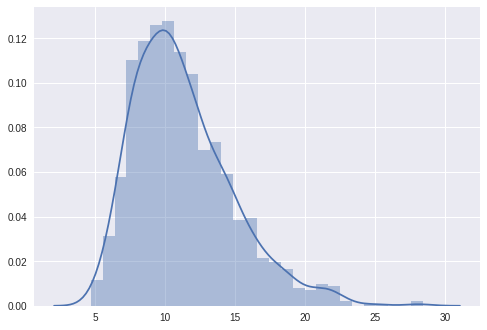

In [0]:
sns.distplot(SNR)


In [0]:

ReplacePath = 'Drive/My Drive/Deeplearning Assignment/timit-homework/te/'

fileNameList = [filelist.replace(ReplacePath,'') for filelist in sorted(glob.glob(dirpath+'/te/tex*'))]
OutputDirPath = 'Drive/My Drive/Deeplearning Assignment/timit-homework/Predictions on Test/'


In [0]:
# ### create test files


# for xComplex,xMag,filename in zip(dictOfTestXFiles['spectrogramList'],
#                                        dictOfTestXFiles['spectrogram_MagList'],
#                                         fileNameList):

#   timeStepsInp = 200
  
#   xMag= np.array([xMag,])
#   YPredMask = sess.run(LastOutput,feed_dict ={X: xMag, timeSteps:timeStepsInp })

#   yPredReadyToWrite = getOutputSound(xComplex,YPredMask)

# #   SNR.append(getSNR(yActAmpVsTime,yPredReadyToWrite))
# #   print(filename)
#   librosa.output.write_wav(OutputDirPath+'Cleaned_'+filename, yPredReadyToWrite, sr = 16000)